<a href="https://colab.research.google.com/github/Hirali04/Language-Translator/blob/main/language_translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
# % matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data = read_text("/content/gdrive/MyDrive/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

### Text Pre-Processing

#### Text Cleaning


In [6]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.',
        'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt 

In [11]:
def remove_attribution(line):
    parts = line.split('CC-BY')
    cleaned_line = parts[0].strip()
    return cleaned_line if cleaned_line else None

# Apply the function to each line in the array
deu_eng = np.array([[remove_attribution(line) for line in entry] for entry in deu_eng])

# Remove the last empty string from each array
deu_eng = np.array([list(filter(None, entry)) for entry in deu_eng])

print(deu_eng)

[['go' 'geh']
 ['hi' 'hallo']
 ['hi' 'grüß gott']
 ...
 ['it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors'
  'es ist wohl unmöglich einen vollkommen fehlerfreien korpus zu erreichen\xa0— das liegt in der natur eines solchen gemeinschaftsprojekts doch wenn wir unsere mitglieder dazu bringen können nicht mit sprachen herumzuexperimentieren die sie gerade lernen sondern sätze in ihrer eigenen muttersprache beizutragen dann gelingt es uns vielleicht die zahl der fehler klein zu halten']
 ['i know that adding sentences only in your native or strongest language is probably not as much fun as practicing writing foreign languages but please dont add sentences to the tatoeba corpus if you are not absolutely sure they are correct if you want to practice languages th

We will get rid of the punctuation marks, and then convert the text to lower case.

In [12]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [13]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'es ist wohl unmöglich einen vollkommen fehlerfreien korpus zu erreichen\xa0— das liegt in der natur eines solchen gemeinschaftsprojekts doch wenn wir unsere mitglieder dazu bringen können nicht mit sprachen herumzuexperimentieren die sie gerade lernen sondern sätze in ihrer eigenen muttersprache beizutragen dann gelingt es uns vielleicht die zahl der fehler klein zu halten'],
       ['i know that adding sentences only in your native or strongest language is probably not as much fun as practicing writing foreign languages but please dont add sentences to the tatoeba corpus if you are not absolutely sure th

In [14]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()

    deu_eng[i,1] = deu_eng[i,1].lower()

In [15]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['it may be impossible to get a completely errorfree corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning we might be able to minimize errors',
        'es ist wohl unmöglich einen vollkommen fehlerfreien korpus zu erreichen\xa0— das liegt in der natur eines solchen gemeinschaftsprojekts doch wenn wir unsere mitglieder dazu bringen können nicht mit sprachen herumzuexperimentieren die sie gerade lernen sondern sätze in ihrer eigenen muttersprache beizutragen dann gelingt es uns vielleicht die zahl der fehler klein zu halten'],
       ['i know that adding sentences only in your native or strongest language is probably not as much fun as practicing writing foreign languages but please dont add sentences to the tatoeba corpus if you are not absolutely sure th

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [16]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [17]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

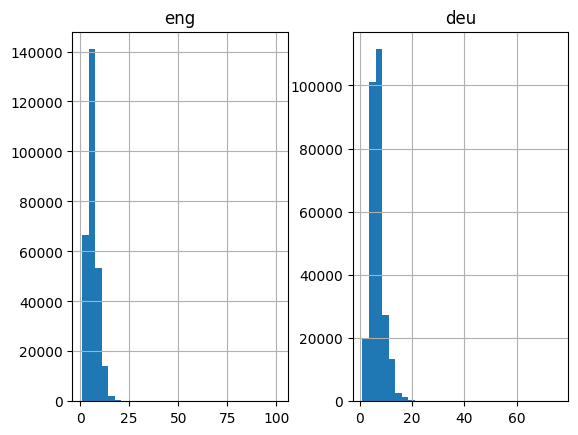

In [18]:
length_df.hist(bins = 30)
plt.show()

In [19]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 25
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 18145


In [21]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 25
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 40258


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [24]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [25]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [26]:
# build model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [28]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [29]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
          epochs=50, batch_size=512,
          validation_split = 0.2,
          verbose=1)

model.save('lang_translator.h5')

Epoch 1/50
348/348 [==============================] - 135s 369ms/step - loss: 1.9521 - val_loss: 1.6749
Epoch 2/50
348/348 [==============================] - 128s 367ms/step - loss: 1.6266 - val_loss: 1.6085
Epoch 3/50
348/348 [==============================] - 128s 366ms/step - loss: 1.6027 - val_loss: 1.6555
Epoch 4/50
348/348 [==============================] - 128s 367ms/step - loss: 1.5907 - val_loss: 1.5898
Epoch 5/50
348/348 [==============================] - 137s 394ms/step - loss: 1.5824 - val_loss: 1.6005
Epoch 6/50
348/348 [==============================] - 128s 369ms/step - loss: 1.5767 - val_loss: 1.5844
Epoch 7/50
348/348 [==============================] - 128s 368ms/step - loss: 1.5717 - val_loss: 1.5847
Epoch 8/50
348/348 [==============================] - 128s 367ms/step - loss: 1.5679 - val_loss: 1.5924
Epoch 9/50
348/348 [==============================] - 137s 394ms/step - loss: 1.5565 - val_loss: 1.5531
Epoch 10/50
348/348 [==============================] - 129s 369m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


comparing the training loss and the validation loss.

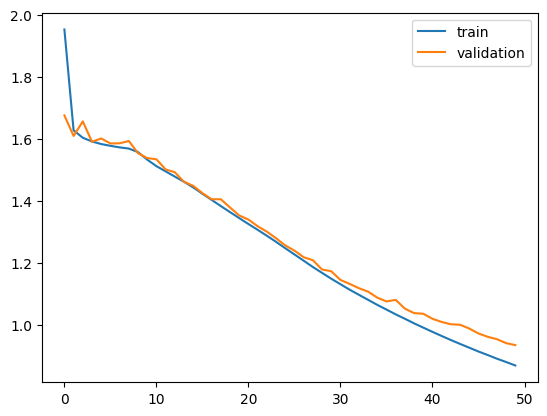

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Predictions

In [ ]:
model = load_model('/content/lang_translator.h5')
preds_prob = model.predict(testX.reshape((testX.shape[0], testX.shape[1])), batch_size=16)

preds = preds_prob.argmax(axis=-1)

In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)

        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(15)

,actual,predicted
0,weve run out of gas,we have out of gas
1,its a fad,this is a
2,tom was shaken,tom was distressed
3,this annoys me,this me
4,let me do that for you,let me do you
5,you will pay for this,youll pay for this
6,tom often cuts classes,tom often to
7,hes young and healthy,he is young angry
8,life is enjoyable,life is beautiful
9,i know it sounds silly,i know it


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [ ]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [ ]:
pred_df.sample(15)

,actual,predicted
4719,id like to know why,id like to know why
6533,i dont need a car,i dont need a car
8505,youve got a fever,you have a fever
6081,dont come again,dont come again
5615,im tired of boston,im am boston
868,i mean no disrespect,i dont want to be
1415,take a number,take a number
3561,what does it say,what does it
1292,shes still young,she is young
7759,youre out of order,youre not normal
